In [1]:
# all neccessary imports
import json
import pandas as pd
import glob
import os
import cv2
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# import google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip /content/drive/MyDrive/Thesis/WLASL.zip

Archive:  /content/drive/MyDrive/Thesis/WLASL.zip
replace WLASL/.git/config? [y]es, [n]o, [A]ll, [N]one, [r]ename: N

N


In [4]:
# Load the JSON file
json_file_path = "/content/WLASL/start_kit/WLASL_v0.3.json"
with open(json_file_path, 'r') as f:
    wlasl_data = json.load(f)

# Convert JSON to DataFrame
df = pd.json_normalize(wlasl_data)

# Unnest the `instances` column
df_unnest = df.explode('instances', ignore_index=True)

# Normalize the `instances` column (flatten nested dictionaries)
instances_df = pd.json_normalize(df_unnest['instances'])

# Combine the normalized instances back to the main DataFrame
df_final = pd.concat([df_unnest.drop(columns=['instances']), instances_df], axis=1)

# Save final DataFrame and show first 5 rows
print(df_final.head())

  gloss                 bbox  fps  frame_end  frame_start  instance_id  \
0  book  [385, 37, 885, 720]   25         -1            1            0   
1  book  [190, 25, 489, 370]   25         -1            1            1   
2  book   [262, 1, 652, 480]   25         -1            1            2   
3  book  [123, 19, 516, 358]   25         60            1            3   
4  book   [95, 0, 1180, 720]   25         -1            1            4   

   signer_id        source  split  \
0        118      aslbrick  train   
1         90   aslsignbank  train   
2        110  valencia-asl  train   
3        113    lillybauer  train   
4        109  valencia-asl  train   

                                                 url  variation_id video_id  
0       http://aslbricks.org/New/ASL-Videos/book.mp4             0    69241  
1  https://aslsignbank.haskins.yale.edu/dictionar...             0    65225  
2        https://www.youtube.com/watch?v=0UsjUE-TXns             0    68011  
3        https://www

In [5]:
# adding columns for xmin, ymin, xmax and ymax from bounding box values
for index, row in df_final.iterrows():
  df_final.at[index, 'xmin'] = str(row['bbox'][0])
  df_final.at[index, 'ymin'] = str(row['bbox'][1])
  df_final.at[index, 'xmax'] = str(row['bbox'][2])
  df_final.at[index, 'ymax'] = str(row['bbox'][3])

In [6]:
df_final.head()

,gloss,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,xmin,ymin,xmax,ymax
0,book,"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,385,37,885,720
1,book,"[190, 25, 489, 370]",25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65225,190,25,489,370
2,book,"[262, 1, 652, 480]",25,-1,1,2,110,valencia-asl,train,https://www.youtube.com/watch?v=0UsjUE-TXns,0,68011,262,1,652,480
3,book,"[123, 19, 516, 358]",25,60,1,3,113,lillybauer,train,https://www.youtube.com/watch?v=1QOYOZ3g-aY,0,68208,123,19,516,358
4,book,"[95, 0, 1180, 720]",25,-1,1,4,109,valencia-asl,train,https://www.youtube.com/watch?v=aGtIHKEdCds,0,68012,95,0,1180,720


In [7]:
#dropping redundant column
df_final = df_final.drop(columns=['bbox'])

In [8]:
df_final.head()

,gloss,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,xmin,ymin,xmax,ymax
0,book,25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,385,37,885,720
1,book,25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65225,190,25,489,370
2,book,25,-1,1,2,110,valencia-asl,train,https://www.youtube.com/watch?v=0UsjUE-TXns,0,68011,262,1,652,480
3,book,25,60,1,3,113,lillybauer,train,https://www.youtube.com/watch?v=1QOYOZ3g-aY,0,68208,123,19,516,358
4,book,25,-1,1,4,109,valencia-asl,train,https://www.youtube.com/watch?v=aGtIHKEdCds,0,68012,95,0,1180,720


In [9]:
#creating list of paths for all available videos
res = []

for path in os.listdir("/content/WLASL/start_kit/videos/"):
    # check if current path is a file
    if os.path.isfile(os.path.join("/content/WLASL/start_kit/videos/", path)):
        res.append(path.split(".")[0])

df_final2 = df_final[df_final.video_id.isin(res)]

In [10]:
df_final2.head()

,gloss,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,xmin,ymin,xmax,ymax
0,book,25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,385,37,885,720
10,book,25,-1,1,10,31,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,07069,462,44,949,720
17,book,25,-1,1,17,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,07068,234,17,524,414
22,book,25,-1,1,22,59,asldeafined,train,https://media.asldeafined.com/vocabulary/14666...,0,07070,131,26,526,480
24,book,25,-1,1,24,12,aslsearch,val,http://www.aslsearch.com/signs/videos/book.mp4,0,07099,162,54,528,400


In [11]:
df_final.shape

(21083, 15)

In [12]:
df_final2.shape

(11980, 15)

In [13]:
# getting number of unique classes
len(df_final2.gloss.unique())

2000

In [14]:
# we will take top 500 classes
top_500_classes = df_final2.gloss.value_counts()[:500].index

top_500_classes

Index(['cool', 'before', 'thin', 'go', 'drink', 'help', 'who', 'cousin',
       'computer', 'candy',
       ...
       'ice cream', 'procrastinate', 'dissolve', 'eagle', 'math', 'march',
       'listen', 'limit', 'lecture', 'independent'],
      dtype='object', name='gloss', length=500)

In [15]:
df_final3 = df_final2[df_final2.gloss.isin(top_500_classes)]

In [16]:
df_final3.shape

(4283, 15)

In [17]:
df_final3.gloss.value_counts()

,count
gloss,
before,16
thin,16
cool,16
drink,15
go,15
...,...
boss,7
bottle,7
comfortable,7


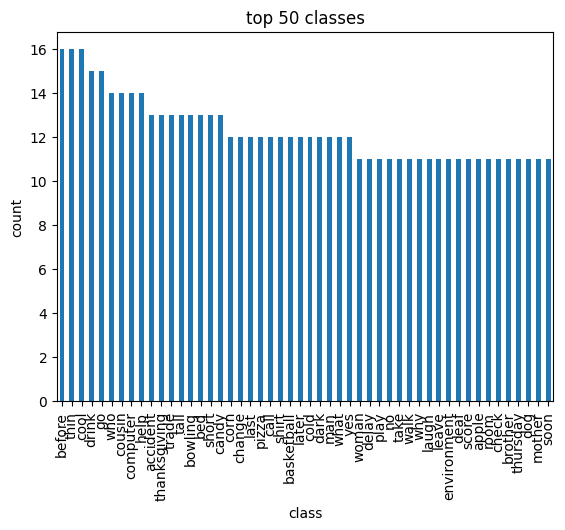

In [18]:

df_final3.gloss.value_counts()[:50].plot(kind='bar')

plt.title('top 50 classes')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

In [19]:
df_final3.head()

,gloss,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,xmin,ymin,xmax,ymax
40,drink,25,-1,1,0,115,aslbrick,val,http://aslbricks.org/New/ASL-Videos/drink.mp4,0,69302,551,68,1350,1080
41,drink,25,-1,1,1,94,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65539,153,11,488,370
51,drink,25,-1,1,11,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,17710,196,15,521,414
56,drink,25,-1,1,16,12,aslsearch,train,http://www.aslsearch.com/signs/videos/drink-al...,0,17733,186,63,551,400
57,drink,25,-1,1,17,94,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65540,167,19,480,370


In [20]:
# train test split

X = df_final3
y = df_final3.gloss
X_train,X_test,y_train,y_test = train_test_split(X,y , random_state=104,test_size=0.25, shuffle=True)

In [23]:
X_train.shape

(3212, 15)

In [24]:
df_final3.gloss.value_counts()

,count
gloss,
before,16
thin,16
cool,16
drink,15
go,15
...,...
boss,7
bottle,7
comfortable,7


In [25]:
# mapping numeric lable to string label and saving as dictionary
classesMapDict = {}
ct=0
for val in X_train.gloss.unique():
    classesMapDict[val] = ct
    ct = ct+1

print(classesMapDict)

{'down': 0, 'leave': 1, 'can': 2, 'chat': 3, 'when': 4, 'blind': 5, 'white': 6, 'perspective': 7, 'procrastinate': 8, 'letter': 9, 'quick': 10, 'sound': 11, 'bed': 12, 'potato': 13, 'tell': 14, 'russia': 15, 'christmas': 16, 'religion': 17, 'event': 18, 'today': 19, 'what': 20, 'slow': 21, 'giraffe': 22, 'problem': 23, 'choice': 24, 'sick': 25, 'dry': 26, 'weather': 27, 'barely': 28, 'same': 29, 'food': 30, 'train': 31, 'heart': 32, 'bird': 33, 'child': 34, 'before': 35, 'without': 36, 'balloon': 37, 'expensive': 38, 'many': 39, 'benefit': 40, 'music': 41, 'football': 42, 'lie': 43, 'day': 44, 'her': 45, 'underwear': 46, 'carry': 47, 'rise': 48, 'past': 49, 'right': 50, 'brush': 51, 'happy': 52, 'strawberry': 53, 'australia': 54, 'doll': 55, 'smart': 56, 'themselves': 57, 'cold': 58, 'dollar': 59, 'cousin': 60, 'shirt': 61, 'to': 62, 'list': 63, 'weak': 64, 'outside': 65, 'dress': 66, 'party': 67, 'contribute': 68, 'kiss': 69, 'trade': 70, 'new': 71, 'card': 72, 'family': 73, 'memorize

In [28]:

wlasl_videos_path = "/content/WLASL/start_kit/videos"
output_images_path = "/content/processed_data/"
output_labels_path = "/content/processed_data/"

# Function to convert bounding box to YOLO format
def convert_to_yolo_format(width, height, x_min, y_min, x_max, y_max):
    x_center = (x_min + x_max) / 2.0 / width
    y_center = (y_min + y_max) / 2.0 / height
    box_width = (x_max - x_min) / width
    box_height = (y_max - y_min) / height
    return x_center, y_center, box_width, box_height

# Processing each video to get frames
def prep_data(dataF,folderPath):
    # Create directories
    img_path = output_images_path+'/'+folderPath+"/images"
    label_path = output_labels_path+'/'+folderPath+"/labels"
    os.makedirs(img_path, exist_ok=True)
    os.makedirs(label_path, exist_ok=True)
    for index, video_data in dataF.iterrows():
        video_id = video_data['video_id']
        label = classesMapDict[video_data['gloss']]  # class label

        # Check if video exists
        video_path = os.path.join(wlasl_videos_path, f"{video_id}.mp4")
        if not os.path.exists(video_path):
            print(f"Video {video_id} not found. Skipping...")
            continue
        # Extract frames from the video
        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        saved_frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            # Save frame as image
            if frame_count % 20 == 0:
                frame_height, frame_width = frame.shape[:2]
                frame_name = f"{video_id}_frame_{frame_count}.jpg"
                frame_path = os.path.join(img_path, frame_name)
                cv2.imwrite(frame_path, frame)
                frame_path = frame_path.replace('\\', '/')
                x_min = float(video_data['xmin'])
                y_min = float(video_data['ymin'])
                x_max = float(video_data['xmax'])
                y_max = float(video_data['ymax'])
                # Write YOLO annotations if bbox is available
                yolo_bbox = convert_to_yolo_format(frame_width, frame_height, x_min, y_min, x_max, y_max)
                label_file = os.path.join(label_path, f"{video_id}_frame_{frame_count}.txt").replace('\\', '/')
                with open(label_file, 'w') as f:
                    f.write(f"{label} {' '.join(map(str, yolo_bbox))}\n")
                saved_frame_count += 1
            frame_count += 1
        cap.release()

    print("Dataset preparation complete!")


In [29]:
# creating training data
prep_data(X_train,"train")

Dataset preparation complete!


In [30]:
# creating validation data
prep_data(X_test,"val")

Dataset preparation complete!


In [31]:
for k, v in classesMapDict.items():
    print(k)

down
leave
can
chat
when
blind
white
perspective
procrastinate
letter
quick
sound
bed
potato
tell
russia
christmas
religion
event
today
what
slow
giraffe
problem
choice
sick
dry
weather
barely
same
food
train
heart
bird
child
before
without
balloon
expensive
many
benefit
music
football
lie
day
her
underwear
carry
rise
past
right
brush
happy
strawberry
australia
doll
smart
themselves
cold
dollar
cousin
shirt
to
list
weak
outside
dress
party
contribute
kiss
trade
new
card
family
memorize
help
orange
cop
meet
fox
sign
quit
farm
thin
one
flexible
wedding
work
dissolve
speech
point
drink
yes
thirsty
discuss
full
candy
give
egypt
want
daughter
blanket
order
cheat
copy
bar
school
opinion
group
drop
secret
eagle
glass
love
allergy
like
lemon
stress
travel
cafeteria
calm
reason
prepare
graduate
soon
highway
computer
bottle
yesterday
walk
possible
internet
upset
beginning
all
yellow
bad
environment
history
vote
africa
dirty
bowling
describe
open
invest
spirit
join
temperature
transfer
wait
cake


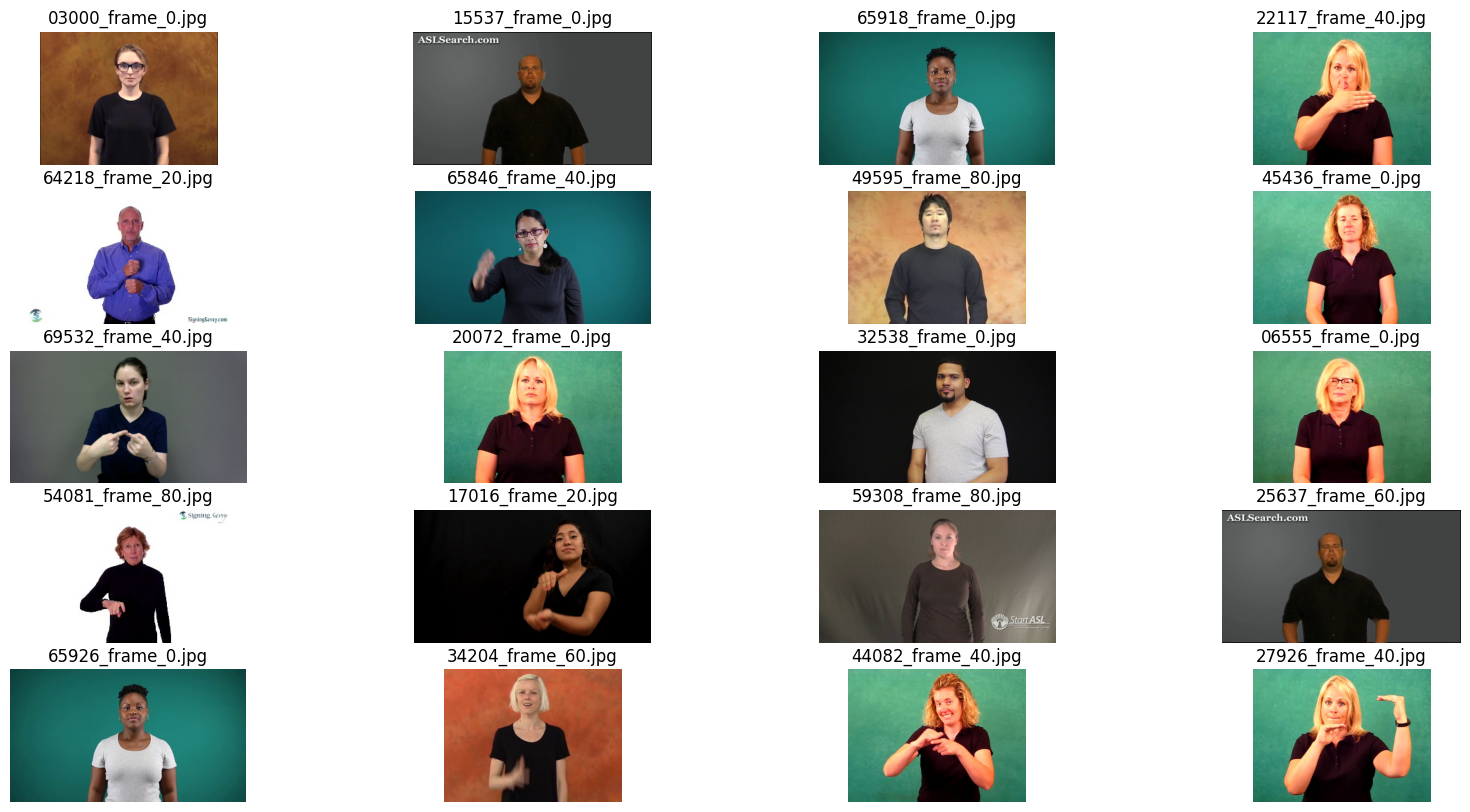

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

image_folder = '/content/processed_data/train/images/'

# Get a list of image files
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

# Show the first 20 images
plt.figure(figsize=(20, 10))
for i in range(min(20, len(image_files))):
    img_path = os.path.join(image_folder, image_files[i])
    lable_path = img_path.replace("images","labels")
    lable_path = lable_path.replace(".jpg",".txt")
    img = mpimg.imread(img_path)
    plt.subplot(5, 4, i + 1)
    plt.imshow(img)
    plt.title(image_files[i])
    plt.axis('off')

plt.show()